In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import cv2
%matplotlib inline
import os

In [3]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [12]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img.astype(np.uint8)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [18]:
train_x = ImageDataGenerator().flow_from_directory(directory='data/train_x',target_size=(200,200),batch_size=10,shuffle=False)
train_y = ImageDataGenerator().flow_from_directory(directory='data/train_y',target_size=(200,200),batch_size=10,shuffle=False)
test_x  = ImageDataGenerator().flow_from_directory(directory='data/test_x' ,target_size=(200,200),batch_size=10,shuffle=False)
test_y  = ImageDataGenerator().flow_from_directory(directory='data/test_y' ,target_size=(200,200),batch_size=10,shuffle=False)

Found 10001 images belonging to 1 classes.
Found 10001 images belonging to 1 classes.
Found 1447 images belonging to 1 classes.
Found 1447 images belonging to 1 classes.


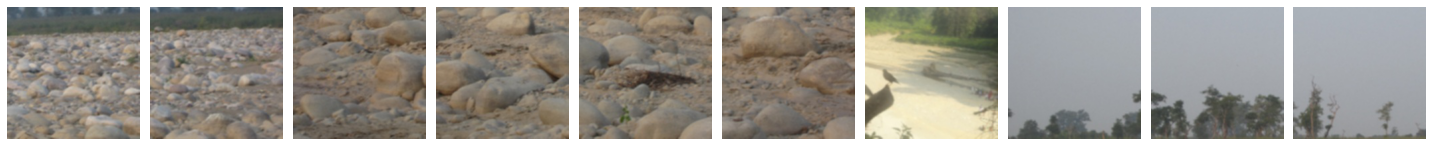

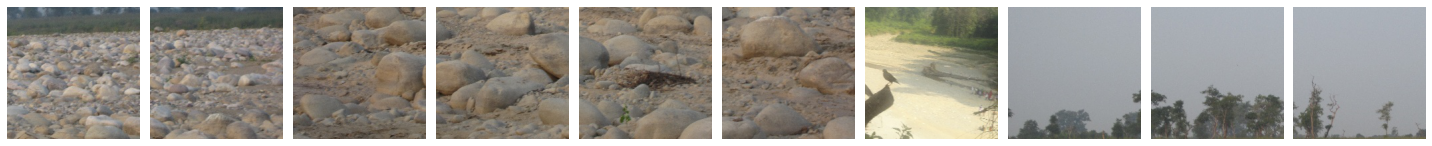

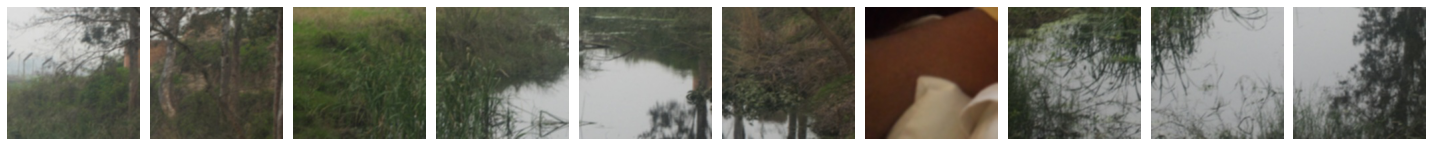

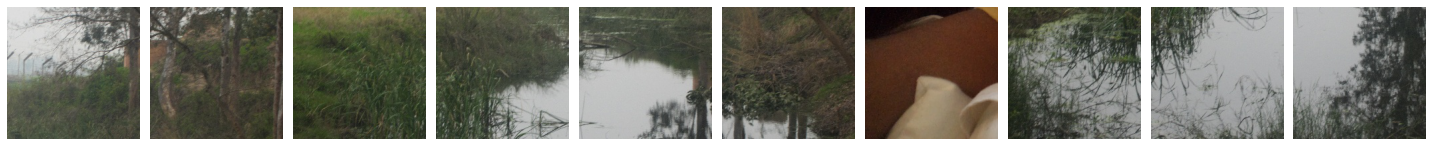

In [21]:
imgs1,_=next(train_x)
imgs2,_=next(train_y)
imgs3,_=next(test_x)
imgs4,_=next(test_y)
plotImages(imgs1)
plotImages(imgs2)
plotImages(imgs3)
plotImages(imgs4)

In [ ]:
def conv_operation(x, filters, kernel_size, strides=1):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size,strides=1):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x